# Stitching Photos with OpenCV

I took a bunch of images of a thing and I want to see if I can stitch them together into a single mosaic of the thing

In [1]:
import cv2
from anutils import data_path
from anutils.cv import rect, transform, joining
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from itertools import combinations
from math import comb
import networkx as nx
from random import choice

# Configuration
fa, fb = figscale = (7, 2)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (4 * fa // fb, 3 * fa // fb)
plt.rcParams['figure.subplot.wspace'] = 0.02
plt.rcParams['figure.subplot.hspace'] = 0.02
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
np.set_printoptions(precision=2)

def disp_img(image, ax=None):
    """
    Fix the color encoding for the image before displaying it
    Since opencv uses a different color map compared to matplotlib \\-.-/
    """
    if len(image.shape) > 2:
        rgbim = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        rgbim = image
    if ax:
        ax.imshow(rgbim)
    else:
        plt.imshow(rgbim)
        plt.show()

def disp_kps(image, keypoints, ax=None):
    d_img = image.copy()
    cv2.drawKeypoints(d_img, keypoints, d_img)
    disp_img(d_img, ax)
    del d_img

def disp_mtc(img0, kps0, img1, kps1, matches01, ax=None):
    d_img = cv2.drawMatches(img0, kps0, img1, kps1,
                            matches01, None, 
                            flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    with plt.rc_context({'figure.figsize': (18, 6)}):
        disp_img(d_img, ax)
    del d_img

Here I have taken four images of a wall. Gonna plot them here.

Since it's four images, I'll just write out all of the code manually instead of doing a for loop. IMO, it's better as the variables are global and easier to track and ensure order

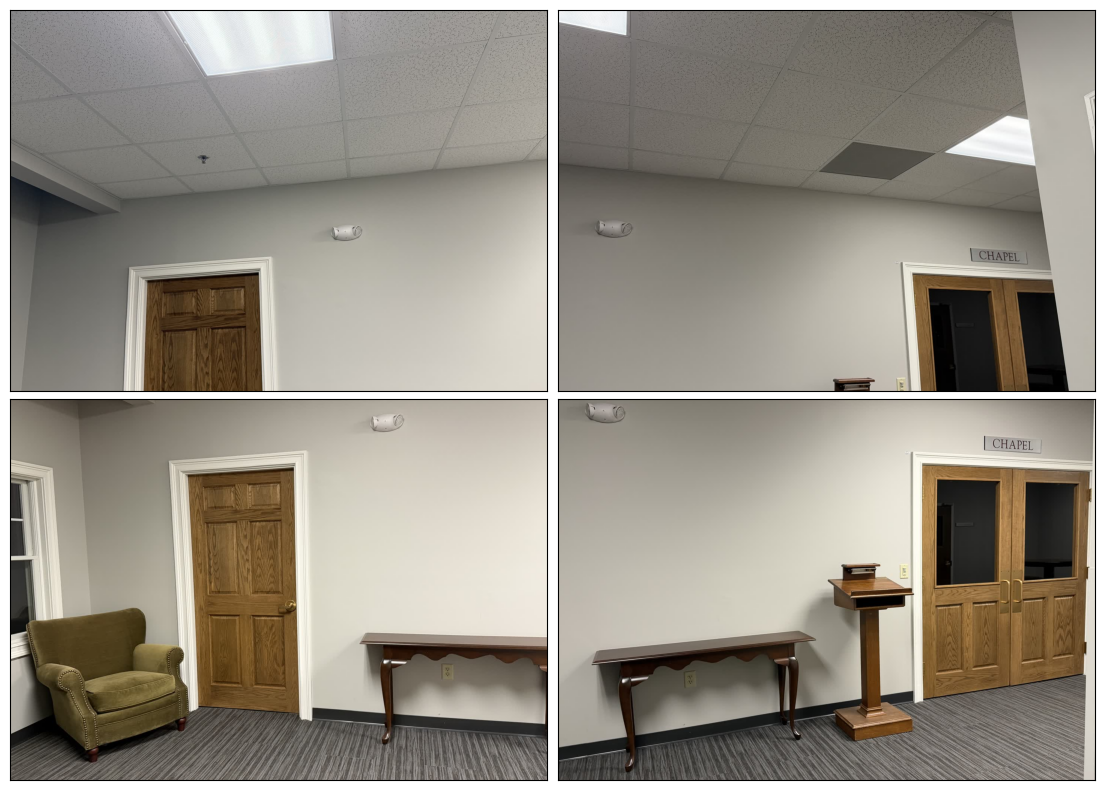

In [2]:
files_dir = data_path / 'stitching-photos'

img0 = cv2.imread(files_dir / 'image0.jpg')
img1 = cv2.imread(files_dir / 'image1.jpg')
img2 = cv2.imread(files_dir / 'image2.jpg')
img3 = cv2.imread(files_dir / 'image3.jpg')

fig, axs = plt.subplots(2,2)
disp_img(img3, axs[0,0])
disp_img(img2, axs[0,1])
disp_img(img0, axs[1,0])
disp_img(img1, axs[1,1])
plt.show()

First off, OpenCV has a built-in `Stitcher` class which can do the stitching for us. Let's see what it comes up with.

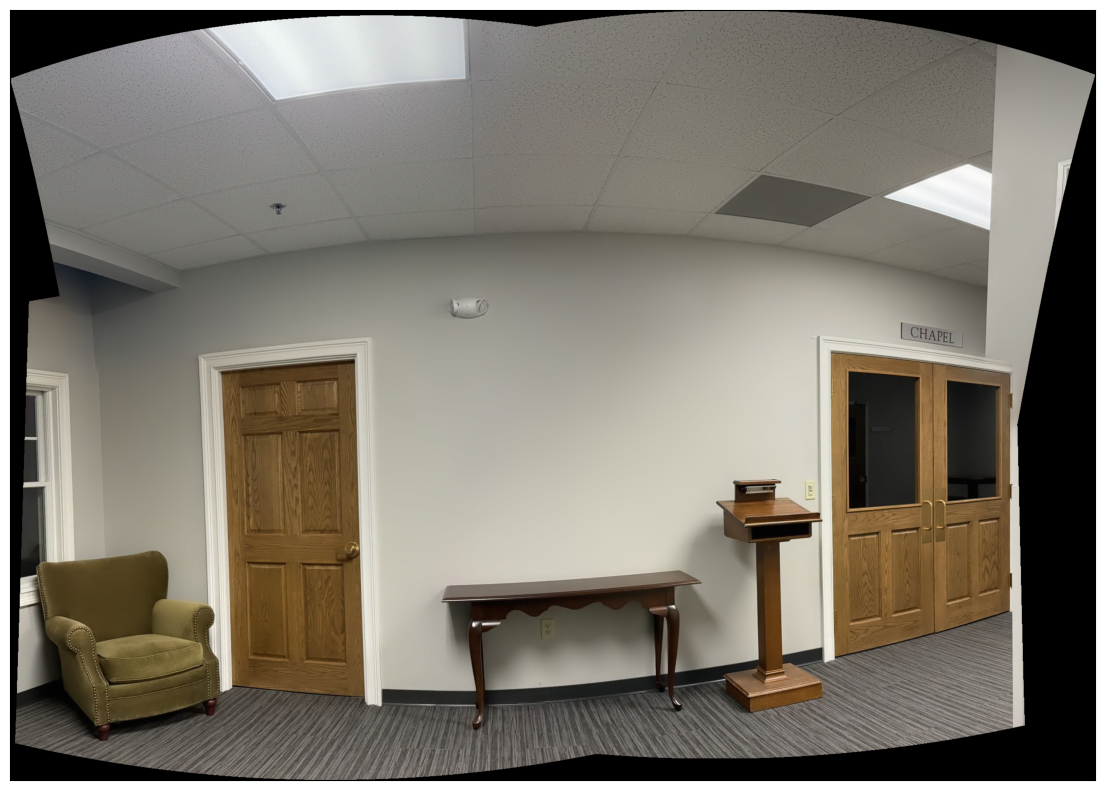

In [3]:
# Create stitcher
stitcher = cv2.Stitcher.create(cv2.Stitcher_PANORAMA)
status, pano = stitcher.stitch([img0, img1, img2, img3])
if status != cv2.Stitcher_OK:
    raise Exception(f'Something went wrong with stitching! Error code: {status}')
disp_img(pano)

So now I wanna do it myself! First step is to detect keypoints in each image. We'll be using SIFT for the keypoint detections

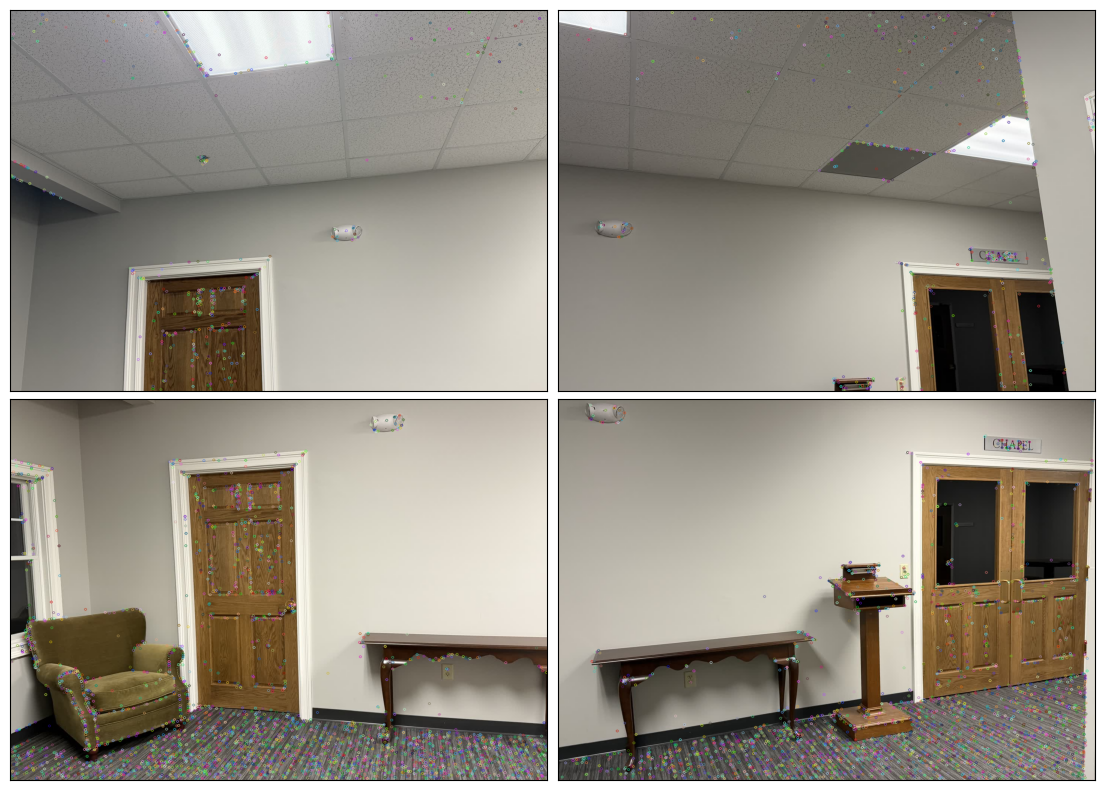

In [4]:
sift = cv2.SIFT.create()

# Get keypoints and descriptors
kps0, dsc0 = sift.detectAndCompute(img0, None)
kps1, dsc1 = sift.detectAndCompute(img1, None)
kps2, dsc2 = sift.detectAndCompute(img2, None)
kps3, dsc3 = sift.detectAndCompute(img3, None)

fig, axs = plt.subplots(2,2)
disp_kps(img3, kps3, axs[0,0])
disp_kps(img2, kps2, axs[0,1])
disp_kps(img0, kps0, axs[1,0])
disp_kps(img1, kps1, axs[1,1])
plt.show()

Normally, we'd find matches and transformations between each image and score each transformation to determine which images connect to each other. However, since I took these photos, I know which photos connect to which other photos already. So, we can manually determine each pair. With each pair, we find the matches between keypoints and compute the most likely homography from the matches

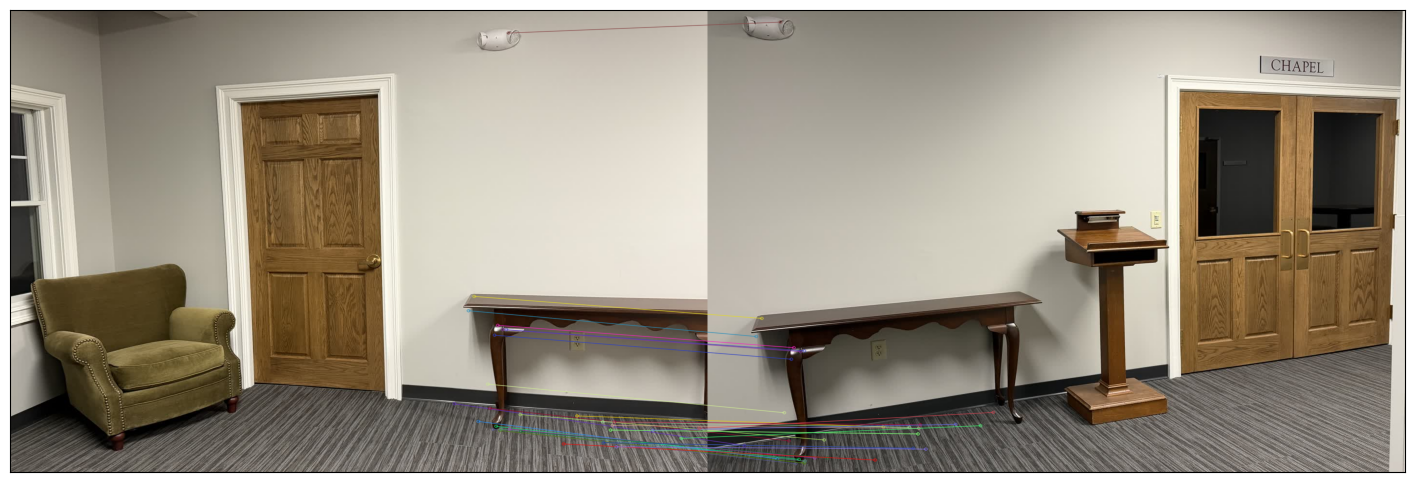

In [5]:
matcher = cv2.BFMatcher()
ratio_thrsh = 0.45
ransac_reproj_thrsh = 7.0

def match_with_ratio_test(trg_dsc, src_dsc):
    """
    Compute matches between source keypoints
    """
    match_groups = matcher.knnMatch(trg_dsc, src_dsc, k=2)
    positive_b = [ m for m in match_groups if m[0].distance > 0 ]
    return [ a for a,b in positive_b if a.distance/b.distance < ratio_thrsh ]

def compute_homography(trg_kps, src_kps, matches):
    """
    Get source and target points ordered by matches 
    and compute the most likely homography between them
    """
    src_pts = np.float32([ src_kps[m.trainIdx].pt for m in matches ])
    trg_pts = np.float32([ trg_kps[m.queryIdx].pt for m in matches ])
    M,_ = cv2.findHomography(src_pts, trg_pts, cv2.RANSAC, ransac_reproj_thrsh)
    return M

# First match (which we'll display to the user)
mtcs10 = match_with_ratio_test(dsc0, dsc1)
H10 = compute_homography(kps0, kps1, mtcs10)
disp_mtc(img0, kps0, img1, kps1, mtcs10)

# Remaining matches
mtcs21 = match_with_ratio_test(dsc1, dsc2)
mtcs30 = match_with_ratio_test(dsc0, dsc3)

# Remaining homographies
H21 = compute_homography(kps1, kps2, mtcs21)
H30 = compute_homography(kps0, kps3, mtcs30)

Here's what one of these transformations looks like

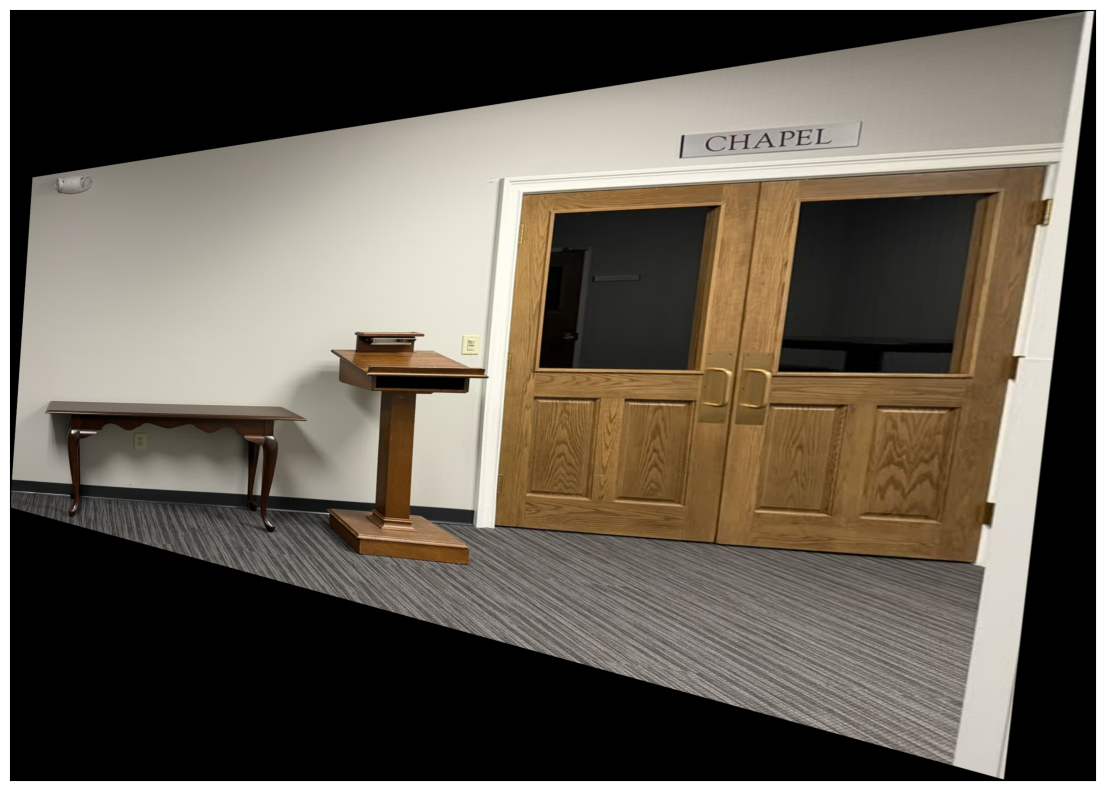

In [6]:
h1,w1 = img1.shape[:2]
rect1 = rect.rect(w1,h1)
w_rect1 = transform.transform(rect1, H10)
w_tl1, w_br1 = w_bbox1 = rect.bounding_box(w_rect1)
w_dims1 = rect.box_dimensions(w_tl1, w_br1)

# Warping the image will shift the image outside the image boundary (beyond 0)
# So, we need to add in a translation back to offset the shift outword
T1 = transform.translation(-w_tl1)
w_img1 = cv2.warpPerspective(img1, T1 @ H10, w_dims1)

disp_img(w_img1)

The other transformation will need to be a composite of two transformations, we'll need to check if this works out correctly

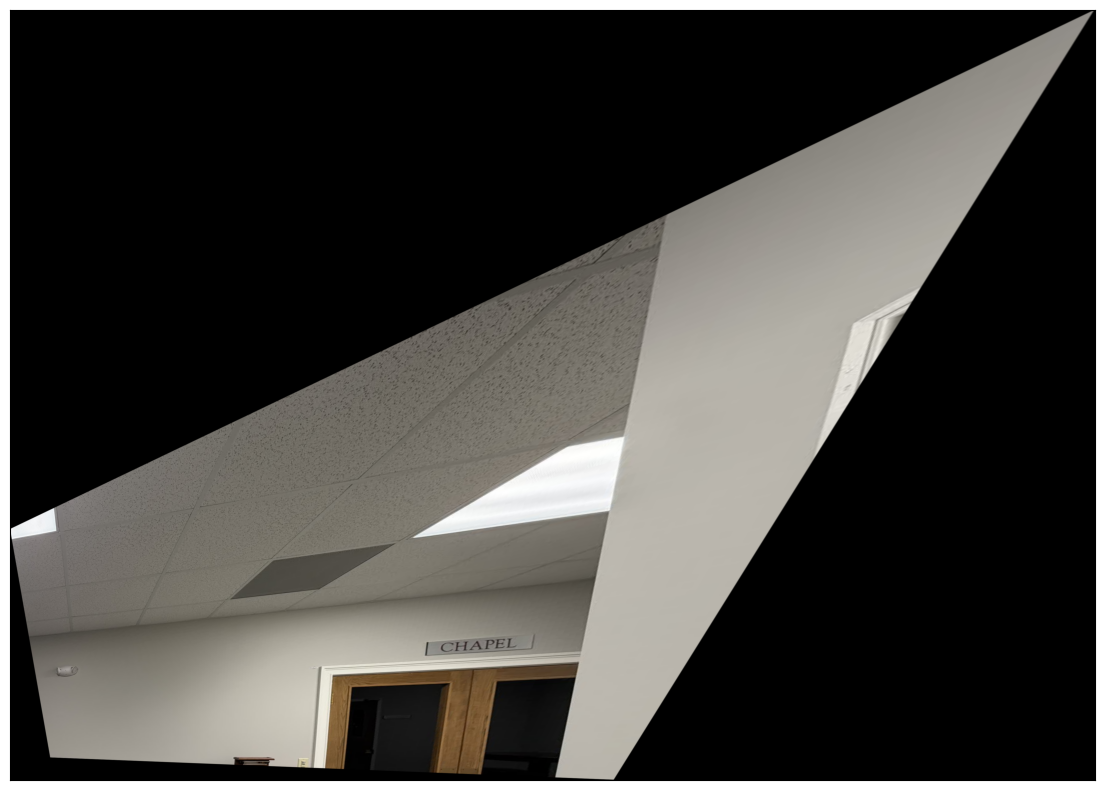

In [7]:
H20 = H10 @ H21
h2,w2 = img2.shape[:2]
rect2 = rect.rect(w2,h2)
w_rect2 = transform.transform(rect2, H20)
w_tl2, w_br2 = w_bbox2 = rect.bounding_box(w_rect2)
w_dims2 = rect.box_dimensions(w_tl2, w_br2)
T2 = transform.translation(-w_tl2)
w_img2 = cv2.warpPerspective(img2, T2 @ H20, w_dims2)

disp_img(w_img2)

So now let's try stitching together two of these images

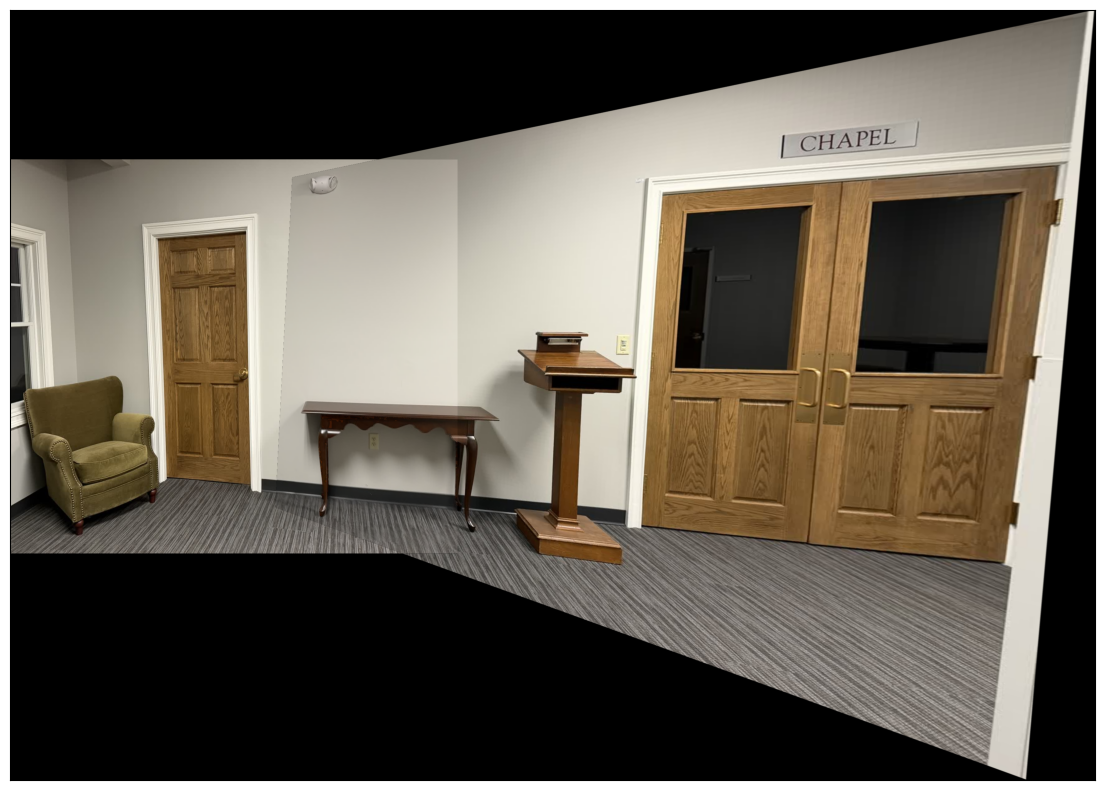

In [8]:
# Find the total bounding box of the fully stitched image 
# Finding the union of both bounding boxes
img_box0 = rect.image_box(img0)
stc_tl10, stc_br10 = stc_box10 = joining.union_box(w_bbox1, img_box0)
stc_dims10 = rect.box_dimensions(stc_tl10, stc_br10)

# There are parts of the image would be outside of the image. 
# So we'll need to translate the box to move the image back into
# The center. To do this, we translate the image so that the top
# left of the bounding box is aligned with the 0,0 part of the image.
# Since we already calculated the total size of the bounding box, this
# will automatically fit the image to the bounding frame
T = transform.translation(-stc_tl10)

# Warp both images and stitch them together. We need to make 
# sure that we translate the image back into the bounding 
# box using our T matrix
w_img0 = cv2.warpPerspective(img0, T, stc_dims10)
w_img1 = cv2.warpPerspective(img1, T @ H10, stc_dims10)
stc_img10 = joining.union_image(w_img1, w_img0)

# Display image
disp_img(stc_img10)

Let's stitch the remaining images

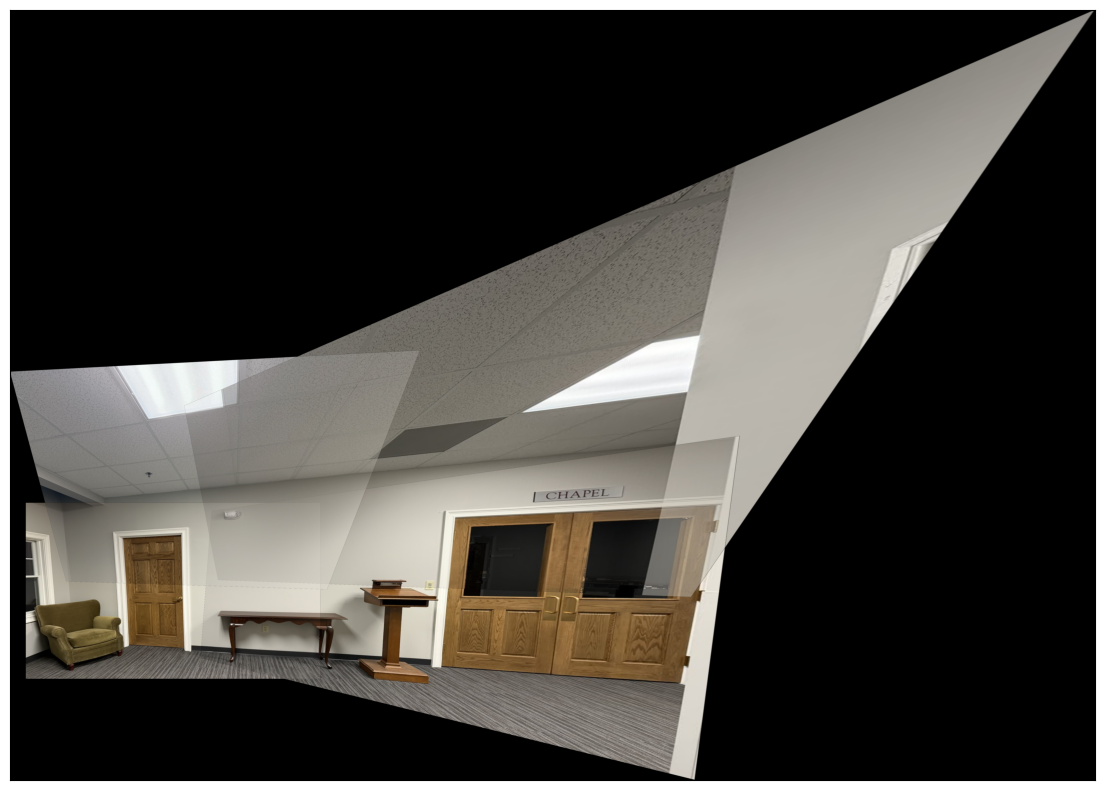

In [9]:
# Get image rects
rect0 = rect.rect(img0.shape[1], img0.shape[0])
rect1 = rect.rect(img1.shape[1], img1.shape[0])
rect2 = rect.rect(img2.shape[1], img2.shape[0])
rect3 = rect.rect(img3.shape[1], img3.shape[0])

# Get transformed rects of images
w_rect1 = transform.transform(rect1, H10)
w_rect2 = transform.transform(rect2, H10 @ H21)
w_rect3 = transform.transform(rect3, H30)

# Find bounding box of whole image
bbox0 = rect.bounding_box(rect0)
w_bbox1 = rect.bounding_box(w_rect1)
w_bbox2 = rect.bounding_box(w_rect2)
w_bbox3 = rect.bounding_box(w_rect3)
stitched_box = joining.union_box(w_bbox1, bbox0)
stitched_box = joining.union_box(w_bbox2, stitched_box)
stitched_box = joining.union_box(w_bbox3, stitched_box)
stitched_dims = rect.box_dimensions(*stitched_box)

# Find the corrective translation
T = transform.translation(-stitched_box[0])

# Warp images
w_img0 = cv2.warpPerspective(img0, T,             stitched_dims)
w_img1 = cv2.warpPerspective(img1, T @ H10,       stitched_dims)
w_img2 = cv2.warpPerspective(img2, T @ H10 @ H21, stitched_dims)
w_img3 = cv2.warpPerspective(img3, T @ H30,       stitched_dims)

# Stitch images together
stitched = joining.union_image(w_img1, w_img0)
stitched = joining.union_image(w_img2, stitched)
stitched = joining.union_image(w_img3, stitched)

# Display image
disp_img(stitched)

It's perfect... beautiful.

Yes I know that it's warped beyond perception and some of the images don't completely line up. To account for that we'd need to account for the camera's projection (spherical projection).

For now, let's focus on how to crop the image so that it's a clean rectangle. First thing is we use our rectangles to create a mask over our image that we can use to find the rectangle that'll crop the image.

Finding rectangle:   0%|          | 0/4725 [00:00<?, ?it/s]

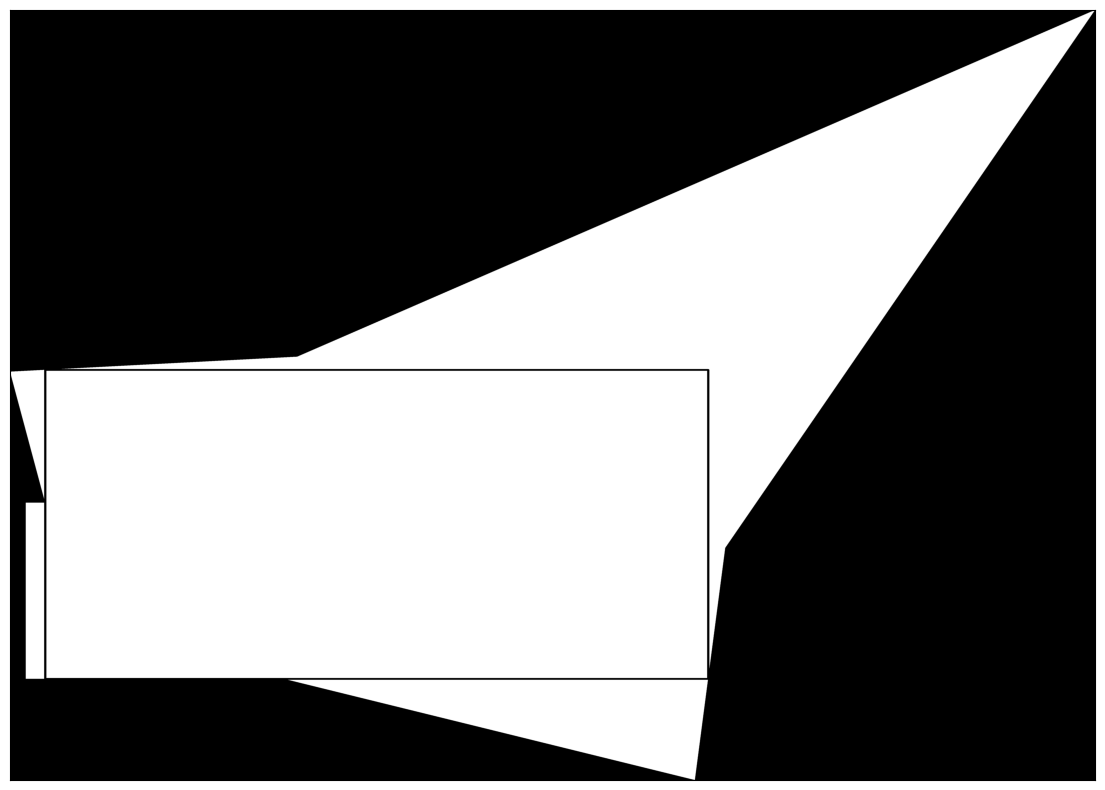

In [10]:
# Transform our rectangle
t_rect0 = transform.transform(rect0, T).astype(np.int32)
t_rect1 = transform.transform(w_rect1, T).astype(np.int32)
t_rect2 = transform.transform(w_rect2, T).astype(np.int32)
t_rect3 = transform.transform(w_rect3, T).astype(np.int32)

# Create empty image with same scale
w,h = stitched_dims
mask = np.zeros((h,w), dtype=np.uint8)
cv2.fillPoly(mask, pts=[t_rect0], color=255)
cv2.fillPoly(mask, pts=[t_rect1], color=255)
cv2.fillPoly(mask, pts=[t_rect2], color=255)
cv2.fillPoly(mask, pts=[t_rect3], color=255)

# Find largest inscribed rectangle (borrowed from chatgpt)
def largest_inscribed_rectangle(mask):
    """
    mask: binary uint8 image (255 = inside polygon, 0 = outside)
    returns (x, y, w, h) for the largest axis-aligned rectangle fully inside mask
    """
    # convert to binary 0/1
    G = (mask > 0).astype(np.uint8)
    H, W = G.shape
    height = np.zeros_like(G, dtype=np.int32)
    best_area = 0
    best_rect = (0, 0, 0, 0)
    for y in tqdm(range(H), desc='Finding rectangle'):
        # update histogram heights
        height[y] = height[y-1] + 1
        height[y][G[y] == 0] = 0
        # largest rectangle in histogram for this row
        stack = []
        x = 0
        row = height[y]
        while x <= W:
            cur_h = row[x] if x < W else 0
            if not stack or cur_h >= row[stack[-1]]:
                stack.append(x)
                x += 1
            else:
                top = stack.pop()
                h = row[top]
                right = x
                left = stack[-1] + 1 if stack else 0
                w = right - left
                area = w * h
                if area > best_area:
                    best_area = area
                    best_rect = (left, y - h + 1, w, h)
    return best_rect

x,y,w,h = largest_inscribed_rectangle(mask)
inscrect = rect.rect(w,h,(x,y)).astype(np.int32)
cv2.polylines(mask, [inscrect], color=0, thickness=10, isClosed=True)
disp_img(mask)

Now we'll use this rectangle to crop our original image so it's actually a filled rectangle

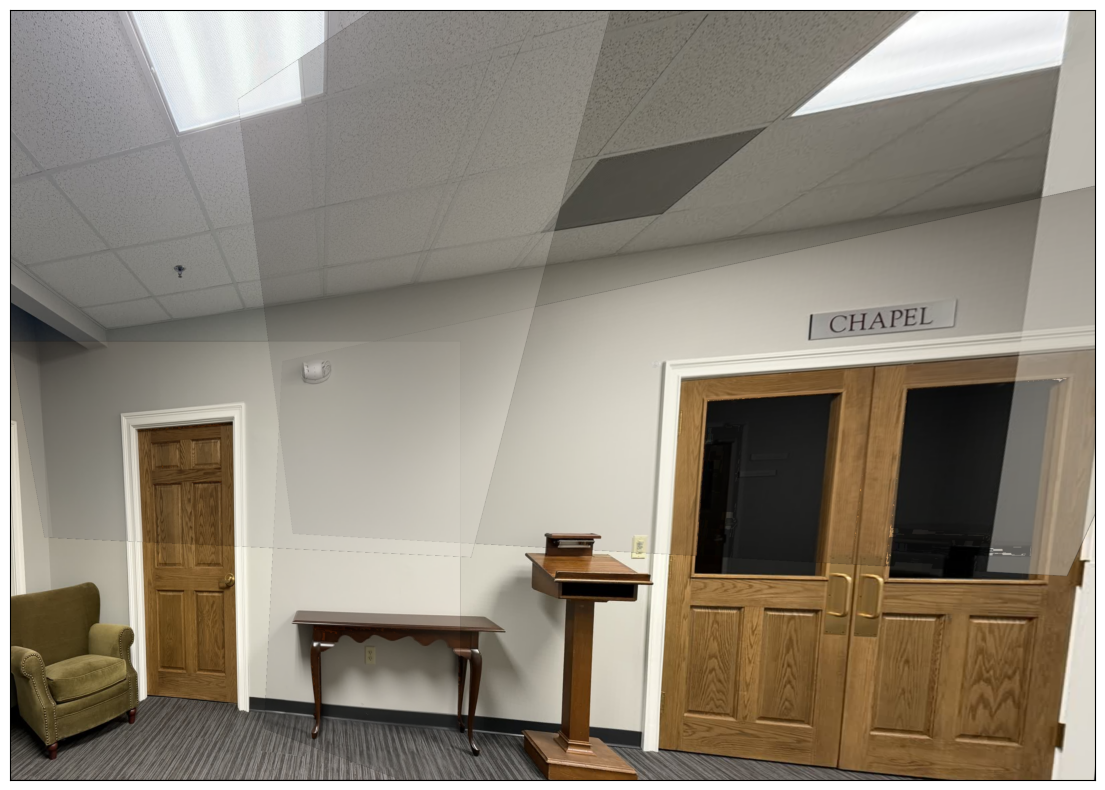

In [11]:
# Cropped image
cropped = stitched[y:y+h,x:x+w]

# Display cropped image
disp_img(cropped)